# Fraud Detector - Minimal Prediction API Example 
#### Supervised fraud detection  
-------

## Setup
------
First setup your AWS credentials so that Fraud Detector can store and access training data and supporting detector artifacts.

https://docs.aws.amazon.com/frauddetector/latest/ug/set-up.html

To use Amazon Fraud Detector, you have to set up permissions that allow access to the Amazon Fraud Detector console and API operations. You also have to allow Amazon Fraud Detector to perform tasks on your behalf and to access resources that you own.

We recommend creating an AWS Identify and Access Management (IAM) user with access restricted to Amazon Fraud Detector operations and required permissions. You can add other permissions as needed.

## Plan
------

You'll need the following pieces of information to make predictions on your dataset. 

- ENTITY_TYPE  
- EVENT_TYPE    
- DETECTOR_NAME & VERSION


You'll also need to identify how many records you'd like to predict on.  


In [1]:
from IPython.core.display import display, HTML
from IPython.display import clear_output
display(HTML("<style>.container { width:90% }</style>"))
# ------------------------------------------------------------------

import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np
np.seterr(divide='ignore', invalid='ignore')


import pandas as pd
import uuid 
from datetime import datetime

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

# -- dask for parallelism -- 
import dask 

# -- standard stuff -- 
import time
from datetime import datetime

# -- AWS stuff -- 
import boto3

%matplotlib inline

## Initialize AWS Fraud Detector Client 
------

https://boto3.amazonaws.com/v1/documentation/api/latest/reference/services/frauddetector.html 


In [2]:
# -- fraud detector client --
client = boto3.client('frauddetector',)

# -- use this to append to files 
sufx   = datetime.now().strftime("%Y%m%d")

### Entity, Detector, Model, and File Information  
-----
<div class="alert alert-info"> 💡 <strong> Entity, Detector, and Files. </strong>

- DETECTOR_NAME & VERSION corresponds to the name and version of your deployed Fraud Detector  
- MODEL_NAME & VERSION corresponds to the name and version of the model deployed with your Fraud Detector   
- S3_BUCKET & S3_FILE this is the information on the S3 file you wish to apply your detector to.   

</div>

In [3]:
ENTITY_TYPE    = "your_entity_type"
EVENT_TYPE     = "your_event_type" 

DETECTOR_NAME = "your_detector_name"
DETECTOR_VER  = "your_detector_version"

# -- name and version of model, used to get the model column names -- 
MODEL_NAME    = "your_model_name"
MODEL_VER     = "your_model_version"

# s3://afd-training-data/schwab_sample_prep.csv

# -- input file of data to be scored -- 
ARN_ROLE      = "your_iam_arn_role" 
S3_BUCKET     = "your_bucket_name"
S3_FILE       = "your_prediction_file.csv"
S3_FILE_LOC   = "s3://{0}/{1}".format(S3_BUCKET,S3_FILE)

# -- run 100 records, you can change this here or below to run the whole file.
record_count = 100

#### Load Data to be Scored 
-----
<div class="alert alert-info"> 💡 <strong> Check the first 5 Records. </strong>

Does your data look correct? Do you need to rename any columns? You want the column names to match the field names used by the Model. 

</div>

In [4]:
# -- connect to S3, snag file, and convert to a panda's dataframe --
s3   = boto3.resource('s3')
obj  = s3.Object(S3_BUCKET, S3_FILE)
body = obj.get()['Body']
df   = pd.read_csv(body)
df.head()

,ip_address,email_address,user_agent,customer_city,customer_state,customer_postal,EVENT_TIMESTAMP,customer_name,customer_address,phone_number,EVENT_LABEL
0,84.138.6.238,synth_tmorton@yahoo.com,Mozilla/5.0 (X11; Linux i686) AppleWebKit/535....,Meganstad,LA,32733.0,2020-04-11 17:27:38,Brandon Moran,824 Price Bypass,(555)784 - 5238,0
1,194.147.250.63,synth_oscott@yahoo.com,Mozilla/5.0 (Macintosh; PPC Mac OS X 10_6_4 rv...,Christinaport,MN,34319.0,2020-04-11 17:31:12,Dominic Murray,13515 Ashley Haven Apt. 472,(555)114 - 6133,0
2,192.54.60.50,synth_aoliver@gmail.com,Mozilla/5.0 (iPad; CPU iPad OS 3_1_3 like Mac ...,Donaldfurt,WA,32436.0,2020-04-11 17:46:34,Anthony Abbott,039 Amy Glens,(555)780 - 7652,0
3,169.120.193.154,synth_clewis@gmail.com,Mozilla/5.0 (Macintosh; PPC Mac OS X 10_10_9; ...,Williamburgh,AL,34399.0,2020-04-11 17:48:52,Kimberly Webb,81397 Tom Forge,(555)588 - 4426,0
4,192.175.55.43,synth_katherinedavis@hotmail.com,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_6_0 ...,East Markland,IL,33690.0,2020-04-11 17:49:23,Renee James,6815 Dawson Estate,(555)785 - 8274,0


## Run Predictions  
-----
The following applies the get_event_prediction endpoint to your recrods in your data frame.    

<i> Note: this uses the Dask backend to parallelize the prediction calls. </i>

<div class="alert alert-info"> 💡 <strong> get_event_prediction </strong>

To specify the number of records to score you change the record_count to a specific number (e.g., if you want to just predict on say 100 records). By default it assumes you want to apply predictions to the whole dataset. Once completed convert json to a pandas dataframe, and appends any existing labels, and analyze based on score threshold for a particular false positive rate (FPR).

</div>

this is all you need to run predictions: 

```python

client.get_event_prediction(detectorId=DETECTOR_NAME, 
                            detectorVersionId=DETECTOR_VERSION,
                            eventId = '222222',
                            eventTypeName = EVENT_TYPE,
                            eventTimestamp = '2020-07-27 12:01:01', 
                            entities = [{'entityType': ENTITY_TYPE, 'entityId':'11111'}],
                            eventVariables=  record)
```


Example of what a record would look like: 

```python
record = [{'order_amt': '8036.0',
  'ip_address': '192.18.59.93',
  'email_address': 'synth_george_hayduke@example.com',
  'cc_bin': '42785',
  'billing_postal': '17740-2745',
  'shipping_postal': '20950-6945',
  'customer_name': 'Geroge Hayduke'}]
```

In [5]:
def get_event_variables(EVENT_TYPE):
    """ return list of variables used by a model 
    
    """
    response = client.get_event_types(name=EVENT_TYPE)
    event_variables = []

    for v in response['eventTypes'][0]['eventVariables']:
        event_variables.append(v)
    return event_variables

event_variables = get_event_variables(EVENT_TYPE)
print("\n -- event variables -- ")
print(event_variables)


 -- event variables -- 
['ip_address', 'email_address', 'user_agent', 'customer_city', 'customer_state', 'customer_postal', 'customer_name', 'customer_address', 'phone_number']


In [6]:
# record_count = df.shape[0] # -- uncomment this to run all of the records -- 
dateTimeObj = datetime.now()
timestampStr = dateTimeObj.strftime("%Y-%m-%dT%H:%M:%SZ")


start = time.time()

@dask.delayed
def _predict(record):
    eventId = uuid.uuid1()
    try:
        pred = client.get_event_prediction(detectorId=DETECTOR_NAME, 
                                       detectorVersionId=DETECTOR_VER,
                                       eventId = str(eventId),
                                       eventTypeName = EVENT_TYPE,
                                       eventTimestamp = timestampStr, 
                                       entities = [{'entityType': ENTITY_TYPE, 'entityId':str(eventId.int)}],
                                       eventVariables=  record) 
        
        record["score"]   = pred['modelScores'][0]['scores']["{0}_insightscore".format(MODEL_NAME)]
        record["outcomes"]= pred['ruleResults'][0]['outcomes']
        return record
    
    except:
        record["score"]   = ["-999"]
        record["outcomes"]= ["error"]
        return record

    
predict_data  = df[event_variables].head(record_count).astype(str).to_dict(orient='records')
predict_score = []

i=0
for record in predict_data:
    clear_output(wait=True)
    rec = dask.delayed(_predict)(record)
    predict_score.append(rec)
    i += 1
    print("current progress: ", round((i/record_count)*100,2), "%" )
    

predict_recs = dask.compute(*predict_score)

# Calculate time taken and print results
time_taken = time.time() - start
tps = len(predict_recs) / time_taken

print ('Process took %0.2f seconds' %time_taken)
print ('Scored %d records' %len(predict_recs))

current progress:  100.0 %
Process took 120.60 seconds
Scored 5000 records


### Take a look at your predictions
-----
Each record will have a score and the outcome of any rule conditions met. 

In [7]:
predictions = pd.DataFrame.from_dict(predict_recs, orient='columns')
predictions.head()

,ip_address,email_address,user_agent,customer_city,customer_state,customer_postal,customer_name,customer_address,phone_number,score,outcomes
0,84.138.6.238,synth_tmorton@yahoo.com,Mozilla/5.0 (X11; Linux i686) AppleWebKit/535....,Meganstad,LA,32733.0,Brandon Moran,824 Price Bypass,(555)784 - 5238,5.0,[approve]
1,194.147.250.63,synth_oscott@yahoo.com,Mozilla/5.0 (Macintosh; PPC Mac OS X 10_6_4 rv...,Christinaport,MN,34319.0,Dominic Murray,13515 Ashley Haven Apt. 472,(555)114 - 6133,4.0,[approve]
2,192.54.60.50,synth_aoliver@gmail.com,Mozilla/5.0 (iPad; CPU iPad OS 3_1_3 like Mac ...,Donaldfurt,WA,32436.0,Anthony Abbott,039 Amy Glens,(555)780 - 7652,5.0,[approve]
3,169.120.193.154,synth_clewis@gmail.com,Mozilla/5.0 (Macintosh; PPC Mac OS X 10_10_9; ...,Williamburgh,AL,34399.0,Kimberly Webb,81397 Tom Forge,(555)588 - 4426,938.0,[review]
4,192.175.55.43,synth_katherinedavis@hotmail.com,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_6_0 ...,East Markland,IL,33690.0,Renee James,6815 Dawson Estate,(555)785 - 8274,16.0,[approve]


### Make a Histogram of Scores 
-----
check out the distrirbution of scores. 

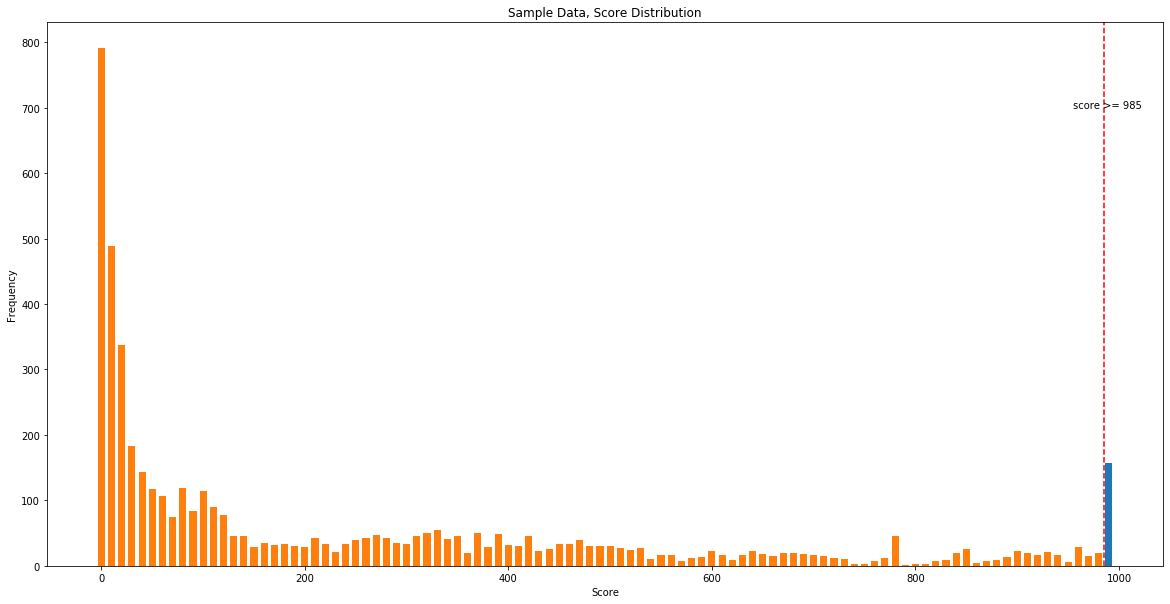

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

predictions['score_bin'] = pd.cut(predictions['score'],100 ,labels= list(range(0,1000,10)))
predictions.loc[predictions['score'] >= 985, 'score_outcome'] = 'predicted fraud'
predictions.loc[predictions['score'] < 985, 'score_outcome'] = 'predicted legit'
ctab = pd.crosstab(predictions['score_bin'], predictions['score_outcome']).reset_index()

plt.figure(figsize=(20,10))
plt.bar(ctab['score_bin'], ctab['predicted fraud'], width=7)
plt.bar(ctab['score_bin'], ctab['predicted legit'], width=7)
plt.axvline(x=985, ls='--', C='red')
plt.title("Sample Data, Score Distribution")
plt.text( 955, 700, 'score >= 985')
plt.xlabel('Score')
plt.ylabel('Frequency')
plt.show()

### Take a look at your prediction outcomes
-----
see the potential impact from actions

In [9]:
predictions['outcomes'] = predictions['outcomes'].astype(str)
pred_summary = predictions.groupby(['outcomes'])['score'].agg(['mean', 'count']).reset_index()
pred_summary['pct_total'] = pred_summary['count']/predictions.shape[0]
pred_summary

,outcomes,mean,count,pct_total
0,['approve'],145.617136,4260,0.8520
1,['block'],995.695402,174,0.0348
2,['friction'],715.832402,358,0.0716
3,['review'],930.423077,208,0.0416


Confusion Matrix by Outcome


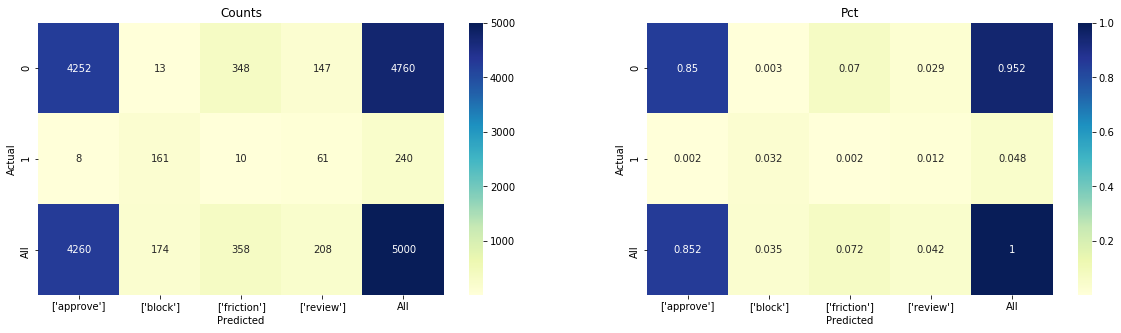

In [16]:


def model_confusion_matrix(predictions):
     
    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(20, 5))
    
    print("Confusion Matrix by Outcome")
    confusion_matrix = pd.crosstab(df['EVENT_LABEL'], predictions['outcomes'].astype(str), margins=True, rownames=['Actual'], colnames=['Predicted'])
    confusion_matrix_pct = pd.crosstab(df['EVENT_LABEL'], predictions['outcomes'].astype(str), normalize="all", margins=True,rownames=['Actual'], colnames=['Predicted']).round(3)
    sns.heatmap(confusion_matrix, annot=True, fmt='g',cmap="YlGnBu", ax=ax1)
    sns.heatmap(confusion_matrix_pct, annot=True, fmt='g',cmap="YlGnBu", ax=ax2)
 
    ax1.title.set_text('Counts')
    ax2.title.set_text('Pct')

    
    plt.show()
    
    
model_confusion_matrix(predictions)

###  Write Predictions to File

-----
writing out predictions to a file allows you to analyze with other tools like QuickSight 

```python

# -- optionally write predictions to a CSV file -- 
predictions.to_csv(FILE + ".csv", index=False)
# -- or to a XLS file 
predictions.to_excel(FILE + ".xlsx", index=False)

```

In [11]:
predictions.to_csv("project_1_5k_predictions.csv", index=False)